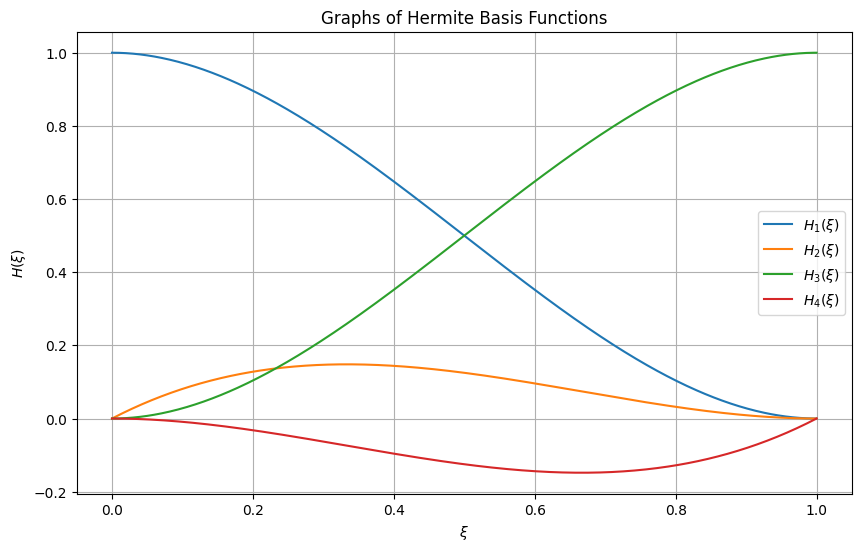

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the Hermite basis functions
def H1(ksi):
    return (1 - ksi)**2 * (1 + 2*ksi)

def H2(ksi, hk=1):
    return ksi * (1 - ksi)**2 * hk

def H3(ksi):
    return ksi**2 * (3 - 2*ksi)

def H4(ksi, hk=1):
    return ksi**2 * (ksi - 1) * hk

# Create an array of ksi values
ksi = np.linspace(0, 1, 500)
hk = 1  # Assuming hk is a constant equal to 1 for H2 and H4

# Evaluate the functions
y1 = H1(ksi)
y2 = H2(ksi, hk)
y3 = H3(ksi)
y4 = H4(ksi, hk)

# Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(ksi, y1, label='$H_1(\\xi)$')
plt.plot(ksi, y2, label='$H_2(\\xi)$')
plt.plot(ksi, y3, label='$H_3(\\xi)$')
plt.plot(ksi, y4, label='$H_4(\\xi)$')

# Add legend and labels
plt.legend()
plt.xlabel('$\\xi$')
plt.ylabel('$H(\\xi)$')
plt.title('Graphs of Hermite Basis Functions')
plt.grid(True)

# Show the plot
plt.show()


In [2]:
sqrt3 = np.sqrt(3)

# Interpolation matrix
H_m = np.array([[(2*sqrt3/9+1./2.),(1./12. + sqrt3/36.),0.5-2*sqrt3/9,-(1./12.-sqrt3/36.)],
                [(0.5-2*sqrt3/9),1./12.-sqrt3/36.,2*sqrt3/9+0.5,-(1./12.+sqrt3/36.)]])

# Second derivative matrix
B_m = np.array([[-2*sqrt3,-(1+sqrt3),2*sqrt3,(1-sqrt3)],
                [2*sqrt3,-(1-sqrt3),-2*sqrt3,(1+sqrt3)]])

def hermite_ocm(n,Th=1.,plot=True):
    """Orthogonal collocation on finite elements with cubic Hermite splines"""

    nel = n - 1
    ndof = 2*n

    he = 1./nel

    M = np.zeros((ndof,ndof))
    rhs = np.zeros(ndof)

    # Symmetry condition at the cneter
    M[0,:] = 0
    M[0,1] = 1

    # Collocation
    # The residual is forced to zero at the collocation points
    # which are chosen as the Gauss quadrature knots

    for k in range(nel):

        rl = 2*k+1
        ru = rl + 2  # We set two rows at a time,

        cl = 2*k
        cu = 2*k + 4  # and four columns

        M[rl:ru,cl:cu] += (1./he**2)*B_m - Th**2*H_m

    # Dirichlet condition
    idr = ndof - 2
    M[ndof-1,:] = 0
    M[ndof-1,ndof-2] = 1.0
    rhs[ndof-1] = 1.0

    U = sp.linalg.solve(M,rhs)
    UT = lambda x, Th: np.cosh(Th*x)/np.cosh(Th)
    xu = np.linspace(0.,1.,n)
    linf = np.linalg.norm(U[0::2] - UT(xu,Th),np.inf)
    print(linf)
    if plot:

        fig, ax = plt.subplots(nrows=1,ncols=1)

        xx = np.linspace(0,1,61)
        ax.plot(xx,np.cosh(Th*xx)/np.cosh(Th),'--',label="Analytic solution")

        xu = np.linspace(0.,1.,n)
        ax.plot(xu,U[0::2],'o',label="Hermite Orthogonal Collocation")

        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$u(x)$")
        ax.set_title(r"Solution of $u''(x) - \mathit{{Th}}\,u(x) = 0$")
        ax.legend()
        plt.show()

1.833779441628991e-07


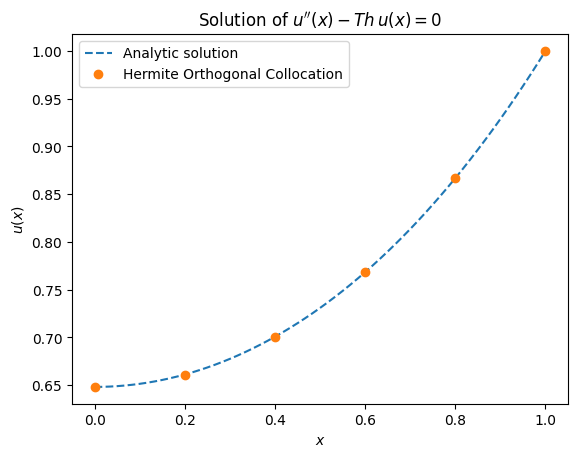

In [3]:
hermite_ocm(6,plot=True)

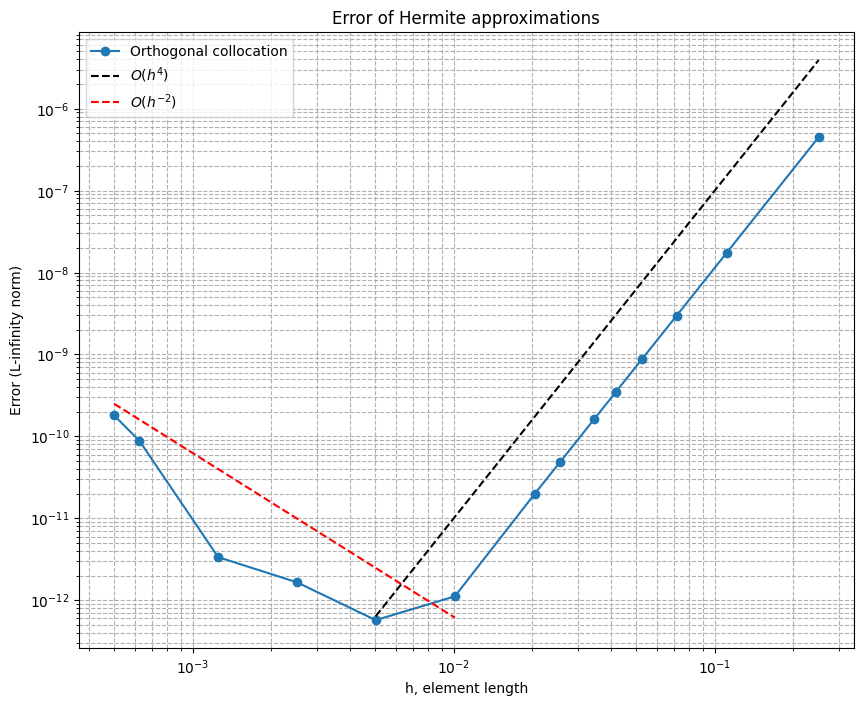

In [29]:
import scipy.sparse.linalg
from scipy import linalg

sqrt3 = np.sqrt(3)
H_m = np.array([[(2*sqrt3/9+1./2.), (1./12. + sqrt3/36.), 0.5-2*sqrt3/9, -(1./12.-sqrt3/36.)],
                [(0.5-2*sqrt3/9), 1./12.-sqrt3/36., 2*sqrt3/9+0.5, -(1./12.+sqrt3/36.)]])
B_m = np.array([[-2*sqrt3, -(1+sqrt3), 2*sqrt3, (1-sqrt3)],
                [2*sqrt3, -(1-sqrt3), -2*sqrt3, (1+sqrt3)]])
# Define the Hermite FEM solver without the plotting part
def hermite_ocm(n, Th=1.):
    nel = n - 1
    ndof = 2*n
    he = 1./nel
    M = np.zeros((ndof, ndof))
    rhs = np.zeros(ndof)
    M[0, :] = 0
    M[0, 1] = 1

    for k in range(nel):
        rl = 2*k+1
        ru = rl + 2
        cl = 2*k
        cu = cl + 4
        M[rl:ru, cl:cu] += (1./he**2) * B_m - Th**2 * H_m

    M[-1, :] = 0
    M[-1, -2] = 1
    rhs[-1] = 1

    U = linalg.solve(M,rhs)
    return U

# Analytical solution function
UT = lambda x, Th: np.cosh(Th*x) / np.cosh(Th)

# Function to calculate the error
def calculate_error(n, Th=1.):
    U = hermite_ocm(n, Th)
    xu = np.linspace(0., 1., n)
    u_analytical = UT(xu, Th)
    linf = np.linalg.norm(U[0::2] - u_analytical, np.inf)
    return linf

# Grid sizes and error calculations
N_values = [5, 10, 15, 20, 25, 30, 40, 50, 100, 200, 400, 800, 1600, 2000]
errors = []
h_values = []

# Calculate errors for different grid sizes
for N in N_values:
    he = 1./(N-1)
    error = calculate_error(N)
    errors.append(error)
    h_values.append(he)


# Plotting the results on a log-log scale
plt.figure(figsize=(10, 8))
plt.loglog(h_values, errors, 'o-', label='Orthogonal collocation')

# Reference lines for O(h^4) and O(h^-2)
h_range = np.array([min(h_values), max(h_values)])
h_range2 = np.array([0.005025125628140704,0.25])
h_range3 = np.array([0.00050025,0.010101010101010102])
plt.loglog(h_range2, (h_range2**4)*0.001 , 'k--', label='$O(h^4)$')
plt.loglog(h_range3, (h_range3**4)[0] * h_range3**(-2)*0.001, 'r--', label='$O(h^{-2})$')

plt.xlabel('h, element length')
plt.ylabel('Error (L-infinity norm)')
plt.title('Error of Hermite approximations')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


In [30]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS 555/Project" # @param {type:"string"}
NOTEBOOK_NAME = "miniapp_h2_element&cubic_Hermite_polynomials.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/
PDF CREATED: /content/drive/My Drive/CS 555/Project/miniapp_h2_element&cubic_Hermite_polynomials.pdf
